# Tweet Sentiment Analysis
**Author: Cem EKE**

In this project, I created a Recurrent Neural Network and implemented it to a Twitter sentiment dataset to learn to recognize emotions in tweets.

Dataset Resource: [Github](https://github.com/dair-ai/emotion_dataset)

## Setup

This problem is a multi-class classification problem in the NLP domain. We will use TensorFlow as our Machine Learning framework.

In [ ]:
# Install nlp package from huggingface.
!pip install nlp

In [ ]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import nlp
import random

# Little helper functions. 

def show_history(h):
  """
  Pass the histroy object that can get from after model training in TensorFlow. 
  Then, this function is simply going to plot the accuracy, the validation 
  accuracy, the loss and the validation loss for that training.
  """  
  epochs_trained = len(h.history['loss'])
  plt.figure(figsize=(16, 6))

  plt.subplot(1, 2, 1)
  plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
  plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
  plt.ylim([0., 1.])
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
  plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

    
def show_confusion_matrix(y_true, y_pred, classes):
  """
  Calculate Confusion Matrix, for the predictions agains ground truth. 
  """
  from sklearn.metrics import confusion_matrix
    
  cm = confusion_matrix(y_true, y_pred, normalize='true')

  plt.figure(figsize=(8, 8))
  sp = plt.subplot(1, 1, 1)
  ctx = sp.matshow(cm)
  plt.xticks(list(range(0, 6)), labels=classes)
  plt.yticks(list(range(0, 6)), labels=classes)
  plt.colorbar(ctx)
  plt.show()

## Dataset

Import dataset with using HuggingFace.

In [ ]:
dataset = nlp.load_dataset('emotion')

Downloading:   0%|          | 0.00/3.41k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/6.01k [00:00<?, ?B/s]

Using custom data configuration default


Downloading:   0%|          | 0.00/1.66M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/204k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/207k [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset emotion downloaded and prepared to /root/.cache/huggingface/datasets/emotion/default/0.0.0/84e07cd366f4451464584cdbd4958f512bcaddb1e921341e07298ce8a9ce42f4. Subsequent calls will reuse this data.


In [ ]:
dataset

{'test': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000),
 'train': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 16000),
 'validation': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000)}

In [ ]:
train = dataset['train']
val = dataset['validation']
test = dataset['test']

In [ ]:
# Extract labels and tweets.

def get_tweets(data):
    tweets = [x['text'] for x in data]
    labels = [x['label'] for x in data]
    return tweets, labels

In [ ]:
tweets, labels = get_tweets(train)

In [ ]:
tweets[0], labels[0]

('i didnt feel humiliated', 'sadness')

## Tokenizing

Use built-in TensorFlow tokenizer.

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer

# Use most freq used ten thousand words ,and anything that isn't present in that freq is tokenized as UNK.

tokenizer = Tokenizer(num_words=10000, oov_token='<UNK>')

tokenizer.fit_on_texts(tweets)

In [ ]:
tokenizer.texts_to_sequences([tweets[1]])

[[2,
  40,
  101,
  60,
  8,
  15,
  494,
  5,
  15,
  3496,
  553,
  32,
  60,
  61,
  128,
  148,
  76,
  1480,
  4,
  22,
  1255]]

In [ ]:
tweets[1]

'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake'

With that way, we got numeric representations for tweets to feed into models.

## Padding and Truncating

The reason to do that because the model that will be created will need a fixed input ship. So, the tweet lengths are different, will have to pad and truncate the sequences.

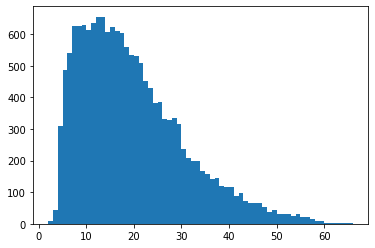

In [ ]:
# Lengths of tweets in training set.

lengths = [len(t.split(' ')) for t in tweets]

plt.hist(lengths, bins = len(set(lengths)))
plt.show()

From the above, we can clearly see that most of the tweets are about 10 or 20 lengths long.

In [ ]:
# Anything that has over 50 words, will be chopped.
# Anything that has less 50 words, will be padded those sequences with zeros.

maxlen = 50

from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
def get_sequences(tokenizer, tweets):
    sequences = tokenizer.texts_to_sequences(tweets)
    padded_sequences = pad_sequences(sequences, truncating='post', maxlen=50, padding='post')
    return padded_sequences

In [ ]:
padded_train_sequences = get_sequences(tokenizer, tweets)

In [ ]:
padded_train_sequences[1]

array([   2,   40,  101,   60,    8,   15,  494,    5,   15, 3496,  553,
         32,   60,   61,  128,  148,   76, 1480,    4,   22, 1255,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0], dtype=int32)

## Label Preparing

Numeric values for different classes.

In [ ]:
classes = set(labels)
print(classes)

{'anger', 'love', 'joy', 'fear', 'surprise', 'sadness'}


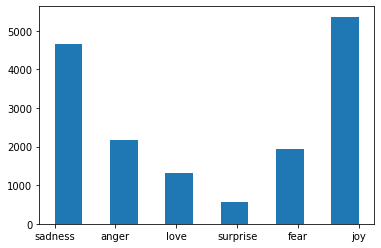

In [ ]:
plt.hist(labels, bins = 11)
plt.show()

In [ ]:
classes_to_index = dict((c, i) for i, c in enumerate(classes))
index_to_classes = dict((v, k) for k, v in classes_to_index.items())

In [ ]:
classes_to_index

{'anger': 0, 'fear': 3, 'joy': 2, 'love': 1, 'sadness': 5, 'surprise': 4}

In [ ]:
index_to_classes

{0: 'anger', 1: 'love', 2: 'joy', 3: 'fear', 4: 'surprise', 5: 'sadness'}

In [ ]:
names_to_ids = lambda labels: np.array([classes_to_index.get(x) for x in labels])

In [ ]:
train_labels = names_to_ids(labels)
print(train_labels[1])

5


## Model Construction

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(10000, 16, input_length = maxlen),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences = True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
    tf.keras.layers.Dense(6, activation = 'softmax')
])

model.compile(
    loss = 'sparse_categorical_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 50, 16)            160000    
                                                                 
 bidirectional_6 (Bidirectio  (None, 50, 40)           5920      
 nal)                                                            
                                                                 
 bidirectional_7 (Bidirectio  (None, 40)               9760      
 nal)                                                            
                                                                 
 dense_3 (Dense)             (None, 6)                 246       
                                                                 
Total params: 175,926
Trainable params: 175,926
Non-trainable params: 0
_________________________________________________________________


## Training

In [ ]:
val_tweets, val_labels = get_tweets(val)
val_sequences = get_sequences(tokenizer, val_tweets)
val_labels = names_to_ids(val_labels)

In [ ]:
val_tweets[0], val_labels[0]

('im feeling quite sad and sorry for myself but ill snap out of it soon', 5)

In [ ]:
history = model.fit(
    padded_train_sequences, train_labels,
    validation_data = (val_sequences, val_labels),
    epochs = 20,
    callbacks = [
        tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', patience = 2)
    ]
)

Epoch 1/20
500/500 [==============================] - 41s 61ms/step - loss: 1.2935 - accuracy: 0.4874 - val_loss: 0.7826 - val_accuracy: 0.7060
Epoch 2/20
500/500 [==============================] - 28s 57ms/step - loss: 0.5605 - accuracy: 0.7846 - val_loss: 0.5796 - val_accuracy: 0.7960
Epoch 3/20
500/500 [==============================] - 28s 56ms/step - loss: 0.3439 - accuracy: 0.8833 - val_loss: 0.4547 - val_accuracy: 0.8595
Epoch 4/20
500/500 [==============================] - 28s 56ms/step - loss: 0.2398 - accuracy: 0.9225 - val_loss: 0.4721 - val_accuracy: 0.8450
Epoch 5/20
500/500 [==============================] - 28s 57ms/step - loss: 0.1834 - accuracy: 0.9413 - val_loss: 0.4718 - val_accuracy: 0.8740
Epoch 6/20
500/500 [==============================] - 29s 57ms/step - loss: 0.1400 - accuracy: 0.9536 - val_loss: 0.4309 - val_accuracy: 0.8805
Epoch 7/20
500/500 [==============================] - 28s 57ms/step - loss: 0.1142 - accuracy: 0.9638 - val_loss: 0.4530 - val_accuracy:

## Evaluating

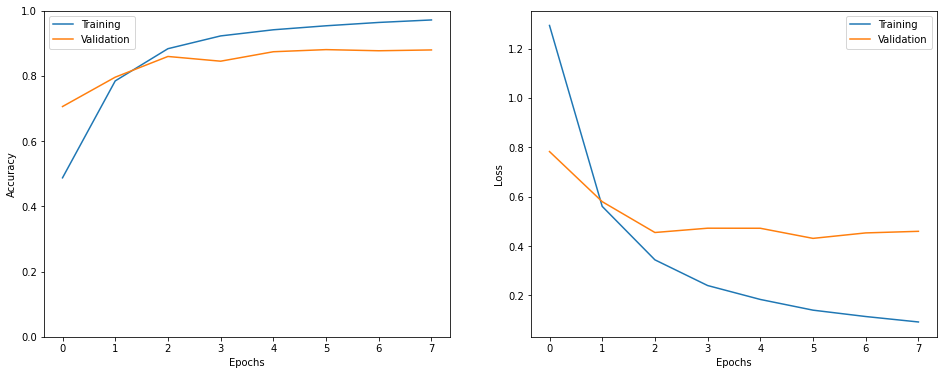

In [ ]:
show_history(history)

In [ ]:
test_tweets, test_labels = get_tweets(test)
test_sequences = get_sequences(tokenizer, test_tweets)
test_labels = names_to_ids(test_labels)

In [ ]:
_ = model.evaluate(test_sequences, test_labels)

63/63 [==============================] - 1s 20ms/step - loss: 0.4441 - accuracy: 0.8840


In [ ]:
i = random.randint(0, len(test_labels) - 1)

print('Sentence:', test_tweets[i])
print('Emotion:', index_to_classes[test_labels[i]])

p = model.predict(np.expand_dims(test_sequences[i], axis = 0))[0]
pred_class = index_to_classes[np.argmax(p).astype('uint8')]

print('Predicted Emotion:', pred_class)

Sentence: i feel the hearts decision to stop caring can it be reversed
Emotion: love
Predicted Emotion: love


In [ ]:
preds = np.argmax(model.predict(test_sequences), axis=-1)

In [ ]:
preds

array([5, 5, 5, ..., 2, 2, 4])

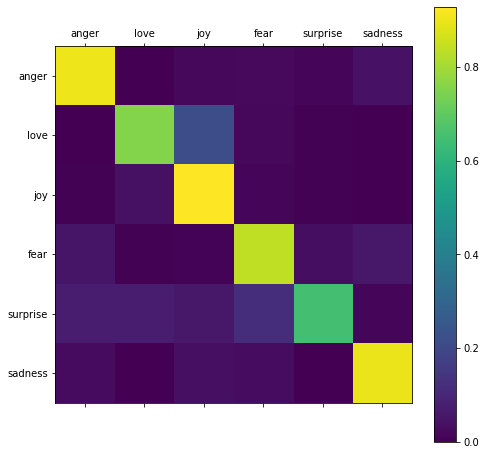

In [ ]:
show_confusion_matrix(test_labels, preds, list(classes))